In this notebook I will generate a Single Stellar Population spectra scale it up based on some star formation history, then run Firefly on it to see how well it can infer the formed mass and stellar masses

In [1]:
import numpy as np 
import astropy.units as U
from astropy.cosmology import FlatLambdaCDM
# --- fomospec --- 
from fomospec import util as UT
from fomospec import fitters as Fitters

In [2]:
# --- plotting ---
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
dir_ssp = ''.join([UT.dat_dir(), 'stellar_population_models/data/SSP_M11_MILES/'])

Z_strs = np.array(['z001', 'z002', 'z004', 'z0001.bhb', 'z0001.rhb', 'z10m4.bhb', 'z10m4.rhb'])
Z = np.array([0.5, 1.0, 2.0, 10**-1.301, 10**-1.302, 10**-2.301, 10**-2.302])

In [4]:
f_ssp_zsol = ''.join([dir_ssp, 'ssp_M11_MILES.cha', Z_strs[1]])

print('SSP file with Z = 1.; %s' % f_ssp_zsol)

SSP file with Z = 1.; /Users/ChangHoon/data/FOMOspec/stellar_population_models/data/SSP_M11_MILES/ssp_M11_MILES.chaz002


In [5]:
age_m, wave_m, flux_m = np.loadtxt(f_ssp_zsol, unpack=True, usecols=[0,2,3])

print('model ages '+' '.join(np.unique(age_m).astype(str))+' Gyrs')

model ages 0.0065 0.007 0.0075 0.008 0.0085 0.009 0.0095 0.01 0.015 0.02 0.025 0.03 0.035 0.04 0.045 0.05 0.055 0.06 0.065 0.07 0.075 0.08 0.085 0.09 0.095 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 1.5 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 Gyrs


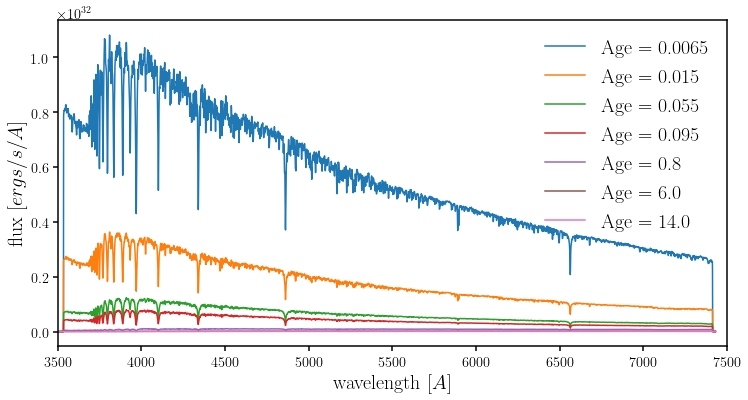

In [6]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
for age in np.unique(age_m)[::8]: 
    isage = (age_m == age)
    sub.plot(wave_m[isage], flux_m[isage], label='Age = '+str(age))
sub.set_xlabel('wavelength [$A$]', fontsize=20)
sub.set_xlim([3.5e3, 7.5e3])
sub.set_ylabel('flux [$ergs/s/A$]', fontsize=20)
sub.legend(loc='upper right', fontsize=20)

In [7]:
cosmo = FlatLambdaCDM(70, 0.3)
t_uni = cosmo.age(0.0)
zred = 0.05

## Test 1: single stellar population
Lets say there's a galaxy at $z=0.05$ with only a single SSP with $\log Z = 0.$ that had star formation $1\,\mathrm{Gyr}$ ago that formed $10^8 M_\odot$. Then here's what the spectrum would look like 

In [8]:
is1gyr = (age_m == 1.)
wave_ssp = wave_m[is1gyr]
flux_ssp = flux_m[is1gyr] * 1e8 / (4. * np.pi * cosmo.luminosity_distance(zred).to(U.cm)**2) * 1e17

Text(0,0.5,'flux [$ergs/s/cm^2/A$]')

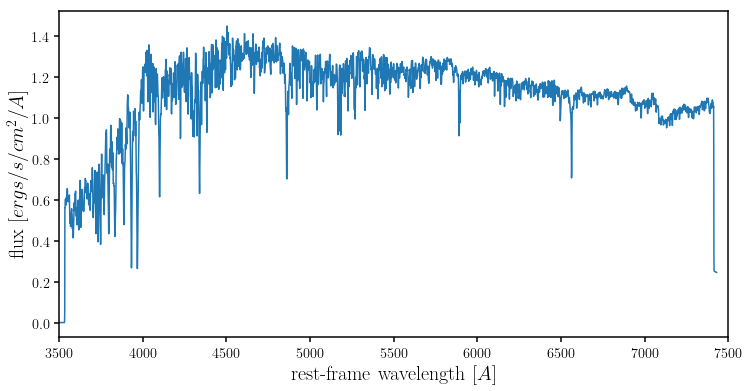

In [9]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
sub.plot(wave_ssp, flux_ssp)
sub.set_xlabel('rest-frame wavelength [$A$]', fontsize=20)
sub.set_xlim([3.5e3, 7.5e3])
sub.set_ylabel('flux [$ergs/s/cm^2/A$]', fontsize=20)

In [19]:
ffly = Fitters.myFirefly(cosmo, model='m11', model_lib='MILES', imf='cha', dust_corr=False, 
                         age_lim=[0., 15.], logZ_lim=[-0.01, 0.01], data_wave_medium=None)
mask = ffly.emissionlineMask(wave_ssp)
ff_fit, ff_prop = ffly.Fit(wave_ssp * (1+zred), flux_ssp, 0.001*flux_ssp, zred, mask=mask)

('extra', [5.9855091769135165e-06, 0.0005985498357434809, 0.05985390615468873, 5.9843134009006285, 597.355723535043, 58675.72123687684, 4946702.746589546, 149637758.08433262, 2.4447039399510038e-06, 0.0002444699515148621], [44365857.32739569, 2392617.245270248, 78667728.83510698, 80220125.27377205, 78810975.48671588, 78151395.3532676, 77795579.94577861, 74155536.37166035, 43963065.96664082, 2908771.2967103417])
('chis', array([5.98551032e+08, 2.44470440e+08, 1.59454820e+08, 1.11636379e+08,
       1.25082717e+08, 6.24766870e+08, 6.65958898e+08, 7.02905384e+08,
       7.23505714e+08, 9.91567849e+08]), array([44365857.32739569,  2392617.24527025, 78667728.83510698,
       80220125.27377205, 78810975.48671588, 78151395.3532676 ,
       77795579.94577861, 74155536.37166035, 43963065.96664082,
        2908771.29671034]))


/Users/ChangHoon/projects/firefly_release/python/firefly_library.py:114: RuntimeWarning: invalid value encountered in true_divide
  return property_pdf,prob_pdf[:-1]/np.sum(prob_pdf)
/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(3500.9, 7428.5)

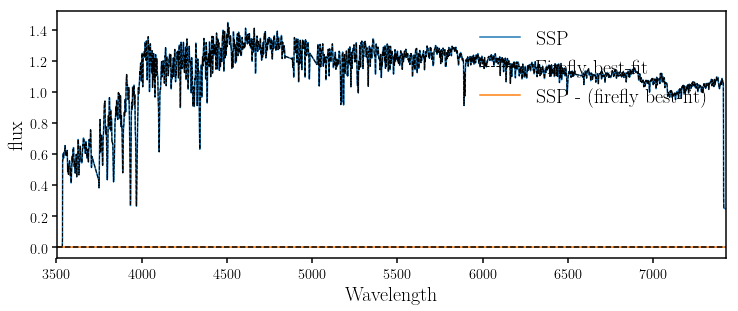

In [20]:
fig = plt.figure(figsize=(12,10))
sub = fig.add_subplot(211)
sub.plot(ff_fit['wavelength'], ff_fit['flux'], label='SSP')
sub.plot(ff_fit['wavelength'], ff_fit['flux_model'], c='k', ls='--', lw=1, label='Firefly best-fit')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([ff_fit['wavelength'].min(), ff_fit['wavelength'].max()])
sub.set_ylabel('flux', fontsize=20)

sub.plot(ff_fit['wavelength'], ff_fit['flux'] - ff_fit['flux_model'], label='SSP - (firefly best-fit)')
sub.plot([ff_fit['wavelength'].min(), ff_fit['wavelength'].max()], [0., 0.], c='k', ls='--')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([ff_fit['wavelength'].min(), ff_fit['wavelength'].max()])


In [21]:
print ff_prop['logM_total'], ff_prop['logM_stellar']

8.00071289681 7.791760804012905


In [22]:
for i in range(ff_prop['n_ssp']): 
    print('--- SSP %i; weight=%f ---' % (i, ff_prop['weightLight_ssp_'+str(i)]))
    print('age = %f'% ff_prop['age_ssp_'+str(i)])
    print('log Z = %f'% ff_prop['logZ_ssp_'+str(i)])
    print('log M_tot = %f' % ff_prop['logM_total_ssp_'+str(i)])

--- SSP 0; weight=1.000000 ---
age = 1.000000
log Z = 0.000000
log M_tot = 8.000000


### Test 2
Combination of two SSP of different ages $10^8M_\odot$ from $1\,Gyr$ SSP and $10^{8.5}M_\odot$ from $5\,Gyr$

In [23]:
is1gyr = (age_m == 1.)
wave_ssp0 = wave_m[is1gyr]
flux_ssp0 = flux_m[is1gyr] * 1e8 / (4. * np.pi * cosmo.luminosity_distance(zred).to(U.cm)**2) * 1e17

is5gyr = (age_m == 5.)
wave_ssp1 = wave_m[is5gyr]
flux_ssp1 = flux_m[is5gyr] * 10**8.5 / (4. * np.pi * cosmo.luminosity_distance(zred).to(U.cm)**2) * 1e17

wave_csp = wave_m[is1gyr]
flux_csp = flux_ssp0 + flux_ssp1

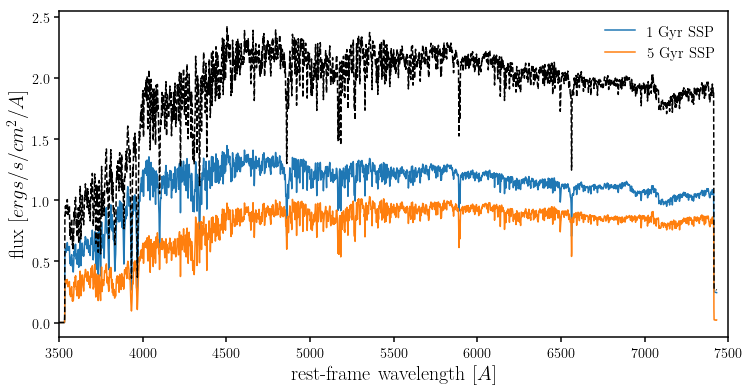

In [24]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(111)
sub.plot(wave_ssp0, flux_ssp0, label='1 Gyr SSP')
sub.plot(wave_ssp1, flux_ssp1, label='5 Gyr SSP')
sub.plot(wave_csp, flux_csp, c='k', ls='--')
sub.set_xlabel('rest-frame wavelength [$A$]', fontsize=20)
sub.set_xlim([3.5e3, 7.5e3])
sub.set_ylabel('flux [$ergs/s/cm^2/A$]', fontsize=20)
sub.legend(loc='upper right', fontsize=15)

In [28]:
ffly = Fitters.myFirefly(cosmo, model='m11', model_lib='MILES', imf='cha', dust_corr=False, data_wave_medium=None,
                         age_lim=[0., 15.], logZ_lim=[-0.01, 0.01])
mask = ffly.emissionlineMask(wave_csp)
ff_fit, ff_prop = ffly.Fit(wave_csp * (1+zred), flux_csp, 0.001*flux_csp, zred, vdisp=0., mask=mask, silent=False)

1. getting the models
2. match model and data resolution
3500.000000 < wavelength < 7429.400000
model has higher wavelength resolution
Normalize the models to the median data flux
Fit model to the data
('extra', [259101.93410466108, 259091.49241066643, 258987.32984192576, 257971.1362039207, 250347.3410800219, 422934.74219144974, 22702893.814757552, 705295073.3760167, 259102.29777890863, 259095.12816687927], [730106.9584004406, 834684.9157632082, 715637.7811076633, 715638.0585176218, 715640.8326063633, 715668.5724096163, 715945.8619681511, 718707.8548396158, 745200.7973474837, 916394.7270973991])
('chis', array([7.50838830e+08, 4.11073357e+08, 2.45798392e+08, 8.94116858e+07,
       1.47253594e+08, 1.86075372e+08, 1.98030731e+08, 2.13800831e+08,
       9.23262545e+08, 1.22601783e+09]), array([730106.95840044, 834684.91576321, 715637.78110766, 715638.05851762,
       715640.83260636, 715668.57240962, 715945.86196815, 718707.85483962,
       745200.79734748, 916394.7270974 ]))
mass weighte

(3500.9, 7428.5)

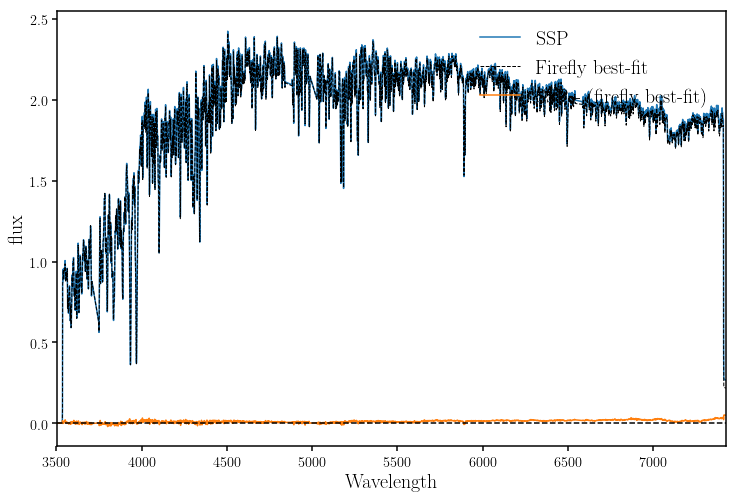

In [29]:
fig = plt.figure(figsize=(12,8))
sub = fig.add_subplot(111)
sub.plot(ff_fit['wavelength'], ff_fit['flux'], label='SSP')
sub.plot(ff_fit['wavelength'], ff_fit['flux_model'], c='k', ls='--', lw=1, label='Firefly best-fit')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([ff_fit['wavelength'].min(), ff_fit['wavelength'].max()])
sub.set_ylabel('flux', fontsize=20)

sub.plot(ff_fit['wavelength'], ff_fit['flux'] - ff_fit['flux_model'], label='SSP - (firefly best-fit)')
sub.plot([ff_fit['wavelength'].min(), ff_fit['wavelength'].max()], [0., 0.], c='k', ls='--')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('Wavelength', fontsize=20)
sub.set_xlim([ff_fit['wavelength'].min(), ff_fit['wavelength'].max()])

In [31]:
print ff_prop['logM_total'], ff_prop['logM_stellar']

8.49968475534 8.26578904648877


In [32]:
for i in range(ff_prop['n_ssp']): 
    print('--- SSP %i; weight=%f ---' % (i, ff_prop['weightLight_ssp_'+str(i)]))
    print('age = %f'% ff_prop['age_ssp_'+str(i)])
    print('log Z = %f'% ff_prop['logZ_ssp_'+str(i)])
    print('log M_tot = %f' % ff_prop['logM_total_ssp_'+str(i)])

--- SSP 0; weight=0.495050 ---
age = 1.000000
log Z = 0.000000
log M_tot = 7.930435
--- SSP 1; weight=0.495050 ---
age = 3.000000
log Z = 0.000000
log M_tot = 8.361900
--- SSP 2; weight=0.009901 ---
age = 0.500000
log Z = 0.000000
log M_tot = 5.983172
